# What's this Clinton

## Introduction

This notebook calculates pluri-annual trends of groundwater levels in each aquifer. This is the exact replica of IGRAC's Code. The time period can be tweaked.

It takes in input:

    - A set of CSV files containing the water level monitoring data. Each CSV file corresponds to an individual aquifer. 

It creates in output:

    - A set of PNG files containing the charts of the water level trends (one aquifer per PNG file).
    
    - A CSV summary file containing the list of aquifers and for each aquifer: the number of observation wells used to calculate the trend, the slope of the trend, whether the trend is stable/rising or declining, etc. This CSV file can be completed with the area of the aquifers.
    

In [1]:
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings; warnings.filterwarnings(action='ignore')

In [2]:
# INITIALIZE THE OUTPUT FILE
list_aquifers = []

# 1. Open input files one by one
This loop will open one input file after the other. See https://stackoverflow.com/questions/18262293/how-to-open-every-file-in-a-folder

Here he is using glob.glob to find all files which are as .csv, then tracing their paths and using them to get the data

A shorter version of the code can be:

master_df = pd.DataFrame()

for file in os.listdir(os.getcwd()):
	if file.endswith('.csv'):
		pd.read_csv



In [3]:
import os
import pandas as pd

master_df = pd.DataFrame()

for file in os.listdir(os.getcwd()):
    if file.endswith('.csv'):
        pd.read_csv(file)

C:\Users\cfe004\AppData\Local\Temp\ipykernel_28796\1668939711.py:8: DtypeWarning: Columns (1,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(file)
C:\Users\cfe004\AppData\Local\Temp\ipykernel_28796\1668939711.py:8: DtypeWarning: Columns (1,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(file)


In [5]:
import os
import pandas as pd

master_df = pd.DataFrame()

for file in os.listdir(os.getcwd()):
    if file.endswith('.csv'):
        pd.read_csv(file, dtype={'1': str, '11': str, '12': str, '13': str}, low_memory=False)


In [ ]:
#import os, glob
#path = '/some/path/to/file'
#for filename in glob.glob(os.path.join(path, '*.csv')):   # only input files must be in csv format!


# 2. Read groundwater level time series

The time series are in a .csv table in the form of: site / date / level

The title of csv files is the name of the aquifer. For example "Aquifer_X.csv"

In [4]:
#Groundwater level time series are in the file WATERLEVEL_demo, read into gdf dataframe
filename = "Central Highveld.csv"
#gdf = pd.DataFrame(pd.read_csv(filename, index_col='date', parse_dates=True, infer_datetime_format=True)) #replace demo file with filename
gdf = pd.DataFrame(pd.read_csv(filename)) #without automatic parsing of dates
gdf['date'] = pd.to_datetime(gdf['date'], format = '%d/%m/%Y')
gdf.set_index('date', inplace=True)
#gdf['level']=-gdf['level']*0.3048 # converting depth to elevation and feet to meters
gdf.head()

,site,level
date,,
2012-10-01,C2N0001,-63.53
2012-11-01,C2N0001,-63.41
2012-12-01,C2N0001,-63.52
2013-02-01,C2N0001,-63.52
2013-03-01,C2N0001,-63.53


There are some cases where borehole names are numbers (as is the case for most boreholes in the US). When they are read into the notebook, they usually have a scientific format. If this happens, sometimes the value is modified. To avoid that, append a   #  symbol in front of each site name in the .csv file.

Now we create a matrix table with one time series per column. We resample this new dataframe to a monthly timescale and create a list of the column names.

In [7]:
#gdf_pivot is new matrix table/dataframe
gdf_pivot = gdf.pivot_table(index='date',columns='site',values='level')
print(gdf_pivot)
rng = pd.period_range('2013-01-01',periods=120, freq='M').to_timestamp() - pd.DateOffset(day=31)
#gdf_pivot = gdf_pivot.resample('M').mean()
gdf_pivot = gdf_pivot.resample('M').mean().reindex(index=rng)
gdf_pivot.index.name = "date"
gdf_pivot

site        C2N0001  C2N0002  C2N0003  C2N0004  C2N0011  C2N0012  C2N0017  \
date                                                                        
2012-10-01   -63.53   -25.40   -26.48   -18.98   -28.86   -14.26    -6.59   
2012-11-01   -63.41      NaN   -26.10   -18.93   -28.94   -14.10      NaN   
2012-12-01   -63.52      NaN   -26.00   -18.90   -28.97   -14.12      NaN   
2013-01-01      NaN      NaN      NaN   -18.71      NaN      NaN      NaN   
2013-02-01   -63.52   -24.61   -26.52   -18.77   -29.11   -14.00    -8.25   
...             ...      ...      ...      ...      ...      ...      ...   
2022-10-01      NaN      NaN      NaN   -18.11   -26.67   -12.01      NaN   
2022-11-01      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2022-12-01   -63.30   -17.88      NaN   -16.92   -26.10   -11.50      NaN   
2023-01-01   -63.39   -18.04   -27.01   -16.48   -25.50   -10.56      NaN   
2023-02-01   -63.38   -18.22      NaN      NaN      NaN      NaN      NaN   

site,C2N0001,C2N0002,C2N0003,C2N0004,C2N0011,C2N0012,C2N0017,C2N0022,C2N0023,C2N0104,...,C2N1141,C2N1142,C2N1143,C2N1144,C2N1145,C2N1146,C2N1147,C2N1148,C2N1149,C2N1150
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,NaN,NaN,NaN,-18.71,NaN,NaN,NaN,NaN,-18.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-28,-63.52,-24.61,-26.52,-18.77,-29.11,-14.00,-8.25,-8.43,-18.52,-12.18,...,-7.69,NaN,NaN,NaN,-16.27,NaN,NaN,NaN,NaN,NaN
2013-03-31,-63.53,-24.10,-26.50,NaN,-29.16,-13.47,NaN,-6.10,NaN,-16.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,-62.53,-24.72,-26.48,-18.87,-29.35,-14.72,NaN,-8.98,-18.60,-12.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-31,-63.53,-24.50,-26.78,-18.81,-29.33,-13.75,-7.92,-8.77,-18.68,-12.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,-63.48,-21.71,NaN,-17.95,-26.46,NaN,NaN,-1.71,NaN,-9.90,...,-4.77,-18.39,-13.13,-12.61,-16.42,-10.49,-10.61,-10.55,-10.57,-17.19
2022-09-30,-65.79,-21.68,-30.20,-18.00,-26.48,-11.70,NaN,-1.94,-19.60,-12.87,...,-4.77,-18.36,-13.16,-12.57,-16.68,-10.49,-10.55,-10.49,-10.51,-17.88
2022-10-31,NaN,NaN,NaN,-18.11,-26.67,-12.01,NaN,-2.47,-19.58,NaN,...,-4.77,-18.38,-13.23,-12.58,-16.67,-10.44,-10.46,-10.48,-10.51,-17.33


## 2. Select period to be used in the evaluation

We are interested in the trends over the last 10 years, from 01-01-2013 to 31/12/2022. In principle the data in input should be within this period, but we resample the data to be sure they are. 

In [8]:
#Select period in "gdf_pivot_1".
gdf_pivot_1 = gdf_pivot.copy()['01-01-2013':'31-12-2022']
gdf_pivot_1

site,C2N0001,C2N0002,C2N0003,C2N0004,C2N0011,C2N0012,C2N0017,C2N0022,C2N0023,C2N0104,...,C2N1141,C2N1142,C2N1143,C2N1144,C2N1145,C2N1146,C2N1147,C2N1148,C2N1149,C2N1150
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,NaN,NaN,NaN,-18.71,NaN,NaN,NaN,NaN,-18.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-28,-63.52,-24.61,-26.52,-18.77,-29.11,-14.00,-8.25,-8.43,-18.52,-12.18,...,-7.69,NaN,NaN,NaN,-16.27,NaN,NaN,NaN,NaN,NaN
2013-03-31,-63.53,-24.10,-26.50,NaN,-29.16,-13.47,NaN,-6.10,NaN,-16.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,-62.53,-24.72,-26.48,-18.87,-29.35,-14.72,NaN,-8.98,-18.60,-12.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-31,-63.53,-24.50,-26.78,-18.81,-29.33,-13.75,-7.92,-8.77,-18.68,-12.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,-63.48,-21.71,NaN,-17.95,-26.46,NaN,NaN,-1.71,NaN,-9.90,...,-4.77,-18.39,-13.13,-12.61,-16.42,-10.49,-10.61,-10.55,-10.57,-17.19
2022-09-30,-65.79,-21.68,-30.20,-18.00,-26.48,-11.70,NaN,-1.94,-19.60,-12.87,...,-4.77,-18.36,-13.16,-12.57,-16.68,-10.49,-10.55,-10.49,-10.51,-17.88
2022-10-31,NaN,NaN,NaN,-18.11,-26.67,-12.01,NaN,-2.47,-19.58,NaN,...,-4.77,-18.38,-13.23,-12.58,-16.67,-10.44,-10.46,-10.48,-10.51,-17.33


The number of observation points available is 128


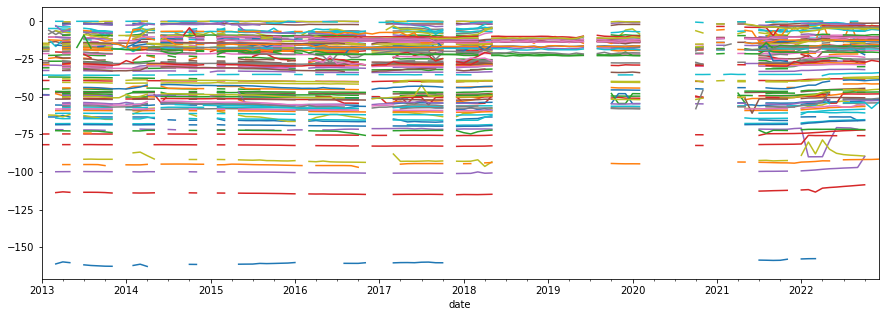

In [9]:
#First glance of the data
gdf_pivot_1.plot(figsize=(15,5), legend=False, xlim=[datetime.date(2013, 1, 1), datetime.date(2022, 12, 31)])
nb_sites_input = gdf_pivot_1.shape[1]
print("The number of observation points available is", nb_sites_input)

## 3. Data filtering
This step consists in removing observation wells from the analysis, for instance if they are incomplete. There are two options:
1. Removing time series if at least one value is missing
2. Removing time series if the percentage of missing values is larger than 70%

In [10]:
# DATA SELECTION
# This step consists in removing observation wells from the analysis, for instance if they are incomplete. 

# gdf_1 = gdf_pivot_1.copy().dropna(axis=1) saved formula to remove all time series if at least one value is missing

# Removing time series if the percentage of missing values is larger than some percentage
perc_months_missing = 0.66

gdf_1 = gdf_pivot_1.copy()
    
max_number_of_monthly_nas = perc_months_missing*gdf_1.shape[0]
gdf_1 = gdf_1.loc[:, (gdf_1.isnull().sum(axis=0) <= max_number_of_monthly_nas)]

nb_sites = gdf_1.shape[1]
print("The number of observation points selected is", nb_sites) 

# Removing time series if data are missing for more than 1 year
gdf_1_year = gdf_1.resample('1y').mean()
gdf_1_year.index.name = "date"
print(gdf_1_year)

nb_years_missing = 1

col_to_drop = [i for i in gdf_1_year.columns if gdf_1_year[i].isnull().sum() > nb_years_missing]
print()
print(col_to_drop)
gdf_1.drop(col_to_drop, inplace = True, axis=1)

nb_sites = gdf_1.shape[1]
print("The number of observation points selected is", nb_sites) 

#gdf_1.plot(figsize=(15,5), legend=None, xlim=[datetime.date(2013, 1, 1), datetime.date(2022, 12, 31)])

The number of observation points selected is 109
site          C2N0001    C2N0002    C2N0003    C2N0004    C2N0011    C2N0012  \
date                                                                           
2013-12-31 -63.417778 -24.760000 -26.825556 -18.934444 -29.626667 -14.557778   
2014-12-31 -64.688750 -24.200000 -27.010000 -18.875556 -29.842857 -13.004286   
2015-12-31 -65.875000 -25.260000 -27.699000 -19.008000 -30.345000 -14.881000   
2016-12-31 -66.383000 -27.110000 -28.208000 -19.162222 -30.935000 -14.792000   
2017-12-31 -66.133000 -27.566667 -28.363000 -18.911818 -30.573000 -14.257000   
2018-12-31 -64.242000 -28.192000 -28.642000 -18.934000 -30.042000 -12.684000   
2019-12-31 -67.120000        NaN -29.780000 -19.220000 -29.000000 -12.780000   
2020-12-31 -65.750000        NaN -29.430000 -19.016667 -29.070000 -12.605000   
2021-12-31 -65.535000 -27.070000 -29.724286 -18.591250 -28.061429 -12.178000   
2022-12-31 -63.714444 -21.195556 -28.428333 -17.758182 -26.715455 -11.6

In [11]:
#Final dataset to work further in the evaluation
gdf_1

site,C2N0001,C2N0003,C2N0004,C2N0011,C2N0012,C2N0022,C2N0104,C2N0180,C2N0198,C2N0204,...,C2N1141,C2N1142,C2N1143,C2N1144,C2N1145,C2N1146,C2N1147,C2N1148,C2N1149,C2N1150
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,NaN,NaN,-18.71,NaN,NaN,NaN,NaN,NaN,NaN,-71.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-28,-63.52,-26.52,-18.77,-29.11,-14.00,-8.43,-12.18,-12.34,NaN,NaN,...,-7.69,NaN,NaN,NaN,-16.27,NaN,NaN,NaN,NaN,NaN
2013-03-31,-63.53,-26.50,NaN,-29.16,-13.47,-6.10,-16.73,-12.49,-20.35,-71.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,-62.53,-26.48,-18.87,-29.35,-14.72,-8.98,-12.29,-12.73,-20.51,-72.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-31,-63.53,-26.78,-18.81,-29.33,-13.75,-8.77,-12.09,-12.41,-20.68,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,-63.48,NaN,-17.95,-26.46,NaN,-1.71,-9.90,-0.54,-18.60,-70.85,...,-4.77,-18.39,-13.13,-12.61,-16.42,-10.49,-10.61,-10.55,-10.57,-17.19
2022-09-30,-65.79,-30.20,-18.00,-26.48,-11.70,-1.94,-12.87,-14.26,-20.07,-71.69,...,-4.77,-18.36,-13.16,-12.57,-16.68,-10.49,-10.55,-10.49,-10.51,-17.88
2022-10-31,NaN,NaN,-18.11,-26.67,-12.01,-2.47,NaN,NaN,NaN,NaN,...,-4.77,-18.38,-13.23,-12.58,-16.67,-10.44,-10.46,-10.48,-10.51,-17.33


## 4. Calculate aquifer-average trend
See https://www.w3schools.com/python/matplotlib_subplot.asp

In [12]:
# dataframe with site / date / level
gdf_melt = gdf_1.copy() #dataframe from step 3
gdf_melt = gdf_melt.unstack().reset_index(name='level')
gdf_melt.set_index('site', inplace=True)
gdf_melt

,date,level
site,,
C2N0001,2013-01-31,NaN
C2N0001,2013-02-28,-63.52
C2N0001,2013-03-31,-63.53
C2N0001,2013-04-30,-62.53
C2N0001,2013-05-31,-63.53
...,...,...
C2N1150,2022-08-31,-17.19
C2N1150,2022-09-30,-17.88
C2N1150,2022-10-31,-17.33


In [13]:
#OBTAIN MEAN WATER LEVEL PER SITE TO THEN SUBTRACT FROM WATER LEVELS - ANOMALY 
waterlevel_means = gdf_melt.reset_index().groupby('site', as_index=False)['level'].mean()
waterlevel_means.set_index('site', inplace=True)
waterlevel_means

,level
site,
C2N0001,-65.114493
C2N0003,-28.078657
C2N0004,-18.761447
C2N0011,-29.468333
C2N0012,-13.681493
...,...
C2N1146,-11.764217
C2N1147,-11.788095
C2N1148,-11.822619


In [14]:
# ASSIGN MEAN WATER LEVEL TO EACH DATA ROW
gdf_melt['mean_level'] = gdf_melt.index.map(waterlevel_means['level'])
gdf_melt

,date,level,mean_level
site,,,
C2N0001,2013-01-31,NaN,-65.114493
C2N0001,2013-02-28,-63.52,-65.114493
C2N0001,2013-03-31,-63.53,-65.114493
C2N0001,2013-04-30,-62.53,-65.114493
C2N0001,2013-05-31,-63.53,-65.114493
...,...,...,...
C2N1150,2022-08-31,-17.19,-18.809277
C2N1150,2022-09-30,-17.88,-18.809277
C2N1150,2022-10-31,-17.33,-18.809277


In [18]:
# Calculate normalized water level "norm_level"
gdf_melt['norm_level'] = gdf_melt['level'] - gdf_melt['mean_level']
gdf_melt 

,date,level,mean_level,norm_level
site,,,,
C2N0001,2013-01-31,NaN,-65.114493,NaN
C2N0001,2013-02-28,-63.52,-65.114493,1.594493
C2N0001,2013-03-31,-63.53,-65.114493,1.584493
C2N0001,2013-04-30,-62.53,-65.114493,2.584493
C2N0001,2013-05-31,-63.53,-65.114493,1.584493
...,...,...,...,...
C2N1150,2022-08-31,-17.19,-18.809277,1.619277
C2N1150,2022-09-30,-17.88,-18.809277,0.929277
C2N1150,2022-10-31,-17.33,-18.809277,1.479277


          date  norm_level
0   2013-01-31    0.412239
1   2013-02-28    0.183843
2   2013-03-31    0.257740
3   2013-04-30   -0.023699
4   2013-05-31    0.081688
..         ...         ...
115 2022-08-31    2.440057
116 2022-09-30    2.078743
117 2022-10-31    2.152907
118 2022-11-30    2.284138
119 2022-12-31    2.788718

[120 rows x 2 columns]


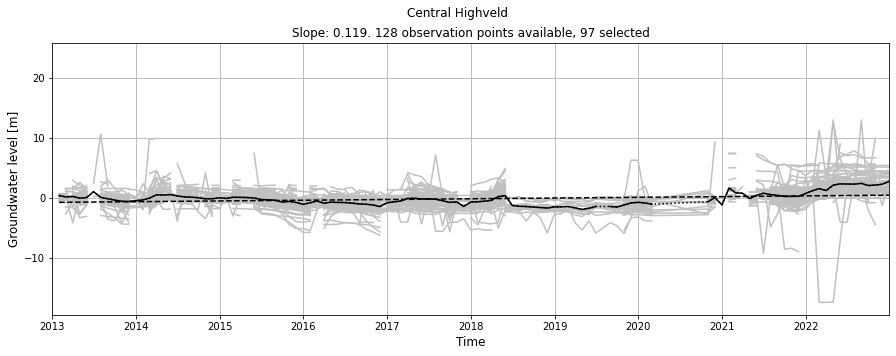

In [76]:
# aquifer-averaged data
final_df1 = gdf_melt[['date', 'norm_level']].groupby('date', as_index=False).mean()
print(final_df1)
final_df1.to_csv('debug.csv', index=False)

# linear trend
final_df1.loc[:, "date"] = pd.to_datetime(final_df1.loc[:, "date"], format="%d-%b-%y")
y_values = final_df1.loc[:, "norm_level"]
x_values = np.linspace(0, 1, len(final_df1.loc[:, "norm_level"]))
    
#cleaning NaN
idx = np.isfinite(x_values) & np.isfinite(y_values)
slope,b = np.polyfit(x_values[idx], y_values[idx], 1)
        
linear_fit = x_values*slope + b

fig, ax = plt.subplots(figsize=(15,5))

gdf_pivot = gdf_melt.pivot_table(index='date',columns='site',values='norm_level')    
plt.plot(gdf_pivot, color='#C0C0C0')     # all the monitoring curves

final_df2=final_df1.dropna()
plt.plot(final_df2.loc[:, "date"], final_df2.loc[:, "norm_level"],color='black', linestyle="dotted") # the composite hydrograph
plt.plot(final_df1.loc[:, "date"], final_df1.loc[:, "norm_level"],color='black') # the composite hydrograph

plt.plot(final_df1.loc[:, "date"], linear_fit, color='#000000', linestyle='dashed') # the linear regression

# axes
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('Groundwater level [m]', fontsize = 12)
ax.grid()
plt.xlim([datetime.date(2013, 1, 1), datetime.date(2022, 12, 31)])

# title
plt.title("Slope: {}. {} observation points available, {} selected".format(round(slope/10, 3), nb_sites_input, nb_sites)) 
   # the slope is calculated over 0 --> 1, it has to be 2013.01.01 --> 2022.12.31 (10 years)
plt.suptitle(filename[:-4])

# save chart as an image
fig.savefig(filename[:-4] + ".jpg", bbox_inches='tight')

plt.show()

# UPDATE THE LIST OF OUTPUTS
list_aquifers.append((filename[:-4], round(slope, 3), nb_sites_input, nb_sites))

In [77]:
#final_df1.reset_index(inplace=True)
year_df = final_df1
print(year_df)
year_df.set_index('date', inplace=True)
year_df = year_df.resample('Y').mean()
year_df.dropna()
year_df['percent_rank'] = year_df.loc[:,'norm_level'].rank(pct=True)
print(year_df)
percentile = year_df.iloc[-1]['percent_rank']
percentile_year = year_df.index[-1]
print("percentile: {}\nyear: {}".format(percentile, percentile_year))

          date  norm_level
0   2013-01-31    0.412239
1   2013-02-28    0.183843
2   2013-03-31    0.257740
3   2013-04-30   -0.023699
4   2013-05-31    0.081688
..         ...         ...
115 2022-08-31    2.440057
116 2022-09-30    2.078743
117 2022-10-31    2.152907
118 2022-11-30    2.284138
119 2022-12-31    2.788718

[120 rows x 2 columns]
            norm_level  percent_rank
date                                
2013-12-31    0.004185           0.7
2014-12-31    0.147927           0.8
2015-12-31   -0.307007           0.6
2016-12-31   -0.877064           0.3
2017-12-31   -0.467756           0.5
2018-12-31   -0.927218           0.2
2019-12-31   -1.372258           0.1
2020-12-31   -0.703166           0.4
2021-12-31    0.590719           0.9
2022-12-31    2.074868           1.0
percentile: 1.0
year: 2022-12-31 00:00:00


## 6. Update summary file

We save the information about this aquifer in the summary file

In [42]:
# Create the pandas DataFrame
output_df = pd.DataFrame(list_aquifers, columns=['aquifer', 'slope', 'nb_sites_input', 'nb_sites'])
output_df.to_csv('Overview.csv', index=False)